In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize, StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import (davies_bouldin_score, silhouette_score, calinski_harabasz_score)
import matplotlib.pyplot as plt
from collections import Counter
import warnings

warnings.filterwarnings('ignore')
pd.options.display.max_columns=200
pd.options.display.max_colwidth=200

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
deleteFeatures = False
useBisRow = 30000
eps = 0.5
min_samples = 10

In [5]:
dt =  pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project/UNSW-NB15_1.csv', header = None, dtype={1: 'object'})
dt.columns = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project/NUSW-NB15_features.csv',encoding='cp1252').Name

In [6]:
data = dt [0:useBisRow]
labels = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project/anomaly_labels.csv')
labels.Label = [-x if x == 1 else 0 for x in labels.Label ]
anomaly_labels = labels.Label[0:useBisRow]

In [7]:
Counter(data["Label"]).keys()

dict_keys([0, 1])

In [8]:
Counter(data["Label"]).values()

dict_values([27617, 2383])

In [9]:
data['service']= np.where(data['service'] == '-', 'None', data['service'])
data['state']= np.where(data['state'] == 'no', 'None', data['state'])
data['is_sm_ips_ports'] = data['is_sm_ips_ports'].astype(bool)
data['is_ftp_login'] = data['is_ftp_login'].astype(bool)
data['ct_state_ttl'] = data['ct_state_ttl'].astype('category')

In [10]:
if deleteFeatures:
  selected_df = data[['service', 'sbytes', 'sttl', 'smeansz', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'Spkts', 'Dload', 'sloss', 'dloss', 'ct_src_ ltm', 'ct_srv_dst' ]]
  num_cols = selected_df.drop(columns = 'service')
  scaler = MinMaxScaler()
  num_cols = scaler.fit_transform(num_cols)
  num_cols = pd.DataFrame(num_cols)
  num_cols.columns = ['sbytes', 'sttl', 'smeansz', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 
                            'Spkts', 'Dload', 'sloss', 'dloss', 'ct_src_ ltm', 'ct_srv_dst']
  cat_cols = selected_df['service']
  labelencoder = LabelEncoder()
  le_value = labelencoder.fit_transform(cat_cols)
  cat_cols = le_value
  onehotcols = pd.DataFrame(cat_cols, columns = ['service'])
  encoder= OneHotEncoder()
  onehotcols = encoder.fit_transform(onehotcols).toarray() 
  onehotdf = pd.DataFrame(onehotcols)
  processed_data = pd.concat([onehotdf, num_cols ], axis =1)

else:
  num_cols=data.select_dtypes(include='number')
  num_cols = num_cols.drop(columns='Label', axis=1)
  scaler = MinMaxScaler()
  num_data = scaler.fit_transform(num_cols)  
  num_data = pd.DataFrame(num_data)
  num_data.columns=num_cols.columns

  cat_cols = data.select_dtypes(exclude='number')
  cat_data=cat_cols.drop(['srcip','dstip','sport','dsport', 'attack_cat'], axis=1)
  cat_data['is_ftp_login']=cat_data['is_ftp_login'].astype('category')
  cat_data['is_sm_ips_ports']=cat_data['is_sm_ips_ports'].astype('category')
  data_dummies = pd.get_dummies(cat_data, drop_first=True)
  processed_data = pd.concat([data_dummies, num_data ], axis =1)

data_model_input = processed_data
data_model_input.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 67 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   proto_icmp            30000 non-null  uint8  
 1   proto_igmp            30000 non-null  uint8  
 2   proto_ospf            30000 non-null  uint8  
 3   proto_sctp            30000 non-null  uint8  
 4   proto_tcp             30000 non-null  uint8  
 5   proto_udp             30000 non-null  uint8  
 6   state_ECO             30000 non-null  uint8  
 7   state_FIN             30000 non-null  uint8  
 8   state_INT             30000 non-null  uint8  
 9   state_REQ             30000 non-null  uint8  
 10  state_RST             30000 non-null  uint8  
 11  state_URH             30000 non-null  uint8  
 12  service_dns           30000 non-null  uint8  
 13  service_ftp           30000 non-null  uint8  
 14  service_ftp-data      30000 non-null  uint8  
 15  service_http       

In [11]:
max_calinski = 0

# Full Model¶

In [12]:
# Defining the agglomerative clustering
dbscan_model = DBSCAN(eps=eps, min_samples=min_samples)

In [13]:
# Fit model
cluster_preds = dbscan_model.fit_predict(data_model_input)

In [14]:
Counter(cluster_preds).keys()

dict_keys([0, 1, -1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 24, 21, 22, 23, 27, 25, 26, 28, 29, 30, 31, 32, 33, 34])

In [15]:
anom_preds = np.where(cluster_preds == -1, -1, 0)

In [16]:
pd.crosstab(anomaly_labels, anom_preds)

col_0,-1,0
Label,,
-1,210,2173
0,191,27426


In [17]:
contingency = pd.DataFrame(pd.crosstab(anomaly_labels, anom_preds) )

tp = contingency.iloc[0,0]
tn = contingency.iloc[1,1]
fp = contingency.iloc[1,0]
fn = contingency.iloc[0,1]

recall = tp / (tp+fn)
print('Recall: {:.2f}'.format(recall))

precision = tp/ (tp+fp)
print('Precision: {:.2f}'.format(precision))

Recall: 0.09
Precision: 0.52


In [18]:
## ratio between the within-cluster dispersion and the between-cluster dispersion.
## higher Calinski-Harabasz score relates to a model with better defined clusters.
calinski = calinski_harabasz_score(data_model_input, anom_preds)

In [19]:
if calinski > max_calinski:
  max_calinski = calinski
  best_data = data_model_input
  print(max_calinski)

77.09073436769074


In [20]:
##  average similarity measure of each cluster with its most similar cluster,
## The minimum score is zero, with lower values indicating better clustering.
davies_bouldin_score(data_model_input, anom_preds)

4.9384947430443

# Model with Selected Features¶

In [21]:
#service_dummy = pd.get_dummies(data['service'], drop_first=True)
#selected_df = pd.concat([num_data[['sttl', 'sbytes', 'smeansz', 'ct_dst_sport_ltm']], service_dummy], axis=1)
data_model_input = num_data[['sttl', 'sbytes', 'smeansz', 'ct_dst_sport_ltm']].copy()

In [22]:
dbscan_model = DBSCAN(eps=eps, min_samples=min_samples)
cluster_preds = dbscan_model.fit_predict(data_model_input)

In [23]:
anom_preds = np.where(cluster_preds == -1, -1, 0)
pd.crosstab(anomaly_labels, anom_preds)

col_0,-1,0
Label,,
-1,4,2379
0,0,27617


In [24]:
calinski = calinski_harabasz_score(data_model_input, anom_preds)

In [25]:
if calinski > max_calinski:
  max_calinski = calinski
  best_data = data_model_input
  print(max_calinski)

In [26]:
davies_bouldin_score(data_model_input, anom_preds)

0.19489536835421378

# Model 1

In [27]:
data_model_input = num_data[['sbytes', 'sttl']].copy()

In [28]:
dbscan_model = DBSCAN(eps=eps, min_samples=min_samples)
cluster_preds = dbscan_model.fit_predict(data_model_input)

In [29]:
anom_preds = np.where(cluster_preds == -1, -1, 0)
pd.crosstab(anomaly_labels, anom_preds)

col_0,-1,0
Label,,
-1,4,2379
0,0,27617


In [30]:
calinski = calinski_harabasz_score(data_model_input, anom_preds)

In [31]:
if calinski > max_calinski:
  max_calinski = calinski
  best_data = data_model_input
  print(max_calinski)

In [32]:
davies_bouldin_score(data_model_input, anom_preds)

0.22421459362817678

# Model 2

In [33]:
data_model_input = num_data[['sbytes', 'sttl', 'dttl']].copy()

In [34]:
dbscan_model = DBSCAN(eps=eps, min_samples=min_samples)
cluster_preds = dbscan_model.fit_predict(data_model_input)

In [35]:
anom_preds = np.where(cluster_preds == -1, -1, 0)
pd.crosstab(anomaly_labels, anom_preds)

col_0,-1,0
Label,,
-1,4,2379
0,0,27617


In [36]:
calinski = calinski_harabasz_score(data_model_input, anom_preds)

In [37]:
if calinski > max_calinski:
  max_calinski = calinski
  best_data = data_model_input
  print(max_calinski)

In [38]:
davies_bouldin_score(data_model_input, anom_preds)

0.22127642082459778

# Model 3

In [39]:
data_model_input = num_data[['sbytes', 'sttl','tcprtt','synack']].copy()

In [40]:
dbscan_model = DBSCAN(eps=eps, min_samples=min_samples)
cluster_preds = dbscan_model.fit_predict(data_model_input)

In [41]:
anom_preds = np.where(cluster_preds == -1, -1, 0)
pd.crosstab(anomaly_labels, anom_preds)

col_0,-1,0
Label,,
-1,4,2379
0,0,27617


In [42]:
calinski = calinski_harabasz_score(data_model_input, anom_preds)

In [43]:
if calinski > max_calinski:
  max_calinski = calinski
  best_data = data_model_input
  print(max_calinski)

In [44]:
davies_bouldin_score(data_model_input, anom_preds)

0.2300758281935568

# Model 4

In [45]:
data_model_input = num_data[['sbytes', 'sttl','tcprtt','synack', 'ackdat']].copy()

In [46]:
dbscan_model = DBSCAN(eps=eps, min_samples=min_samples)
cluster_preds = dbscan_model.fit_predict(data_model_input)

In [47]:
anom_preds = np.where(cluster_preds == -1, -1, 0)
pd.crosstab(anomaly_labels, anom_preds)

col_0,-1,0
Label,,
-1,4,2379
0,0,27617


In [48]:
calinski = calinski_harabasz_score(data_model_input, anom_preds)

In [49]:
if calinski > max_calinski:
  max_calinski = calinski
  best_data = data_model_input
  print(max_calinski)

In [50]:
davies_bouldin_score(data_model_input, anom_preds)

0.2314949662414029

# Model 5

In [51]:
data_model_input = num_data[['sbytes', 'sttl','tcprtt','synack', 'ackdat', 'Sload']].copy()

In [52]:
dbscan_model = DBSCAN(eps=eps, min_samples=min_samples)
cluster_preds = dbscan_model.fit_predict(data_model_input)

In [53]:
anom_preds = np.where(cluster_preds == -1, -1, 0)
pd.crosstab(anomaly_labels, anom_preds)

col_0,-1,0
Label,,
-1,10,2373
0,0,27617


In [54]:
if len(Counter(cluster_preds).keys()) > 1:
  calinski = calinski_harabasz_score(data_model_input, anom_preds)

In [55]:
if calinski > max_calinski:
  max_calinski = calinski
  best_data = data_model_input
  print(max_calinski)

111.22096704973558


In [56]:
if len(Counter(cluster_preds).keys()) > 1:
  davies_bouldin_score(data_model_input, anom_preds)

# Hyperparameter Tuning

In [57]:
best_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sbytes  30000 non-null  float64
 1   sttl    30000 non-null  float64
 2   tcprtt  30000 non-null  float64
 3   synack  30000 non-null  float64
 4   ackdat  30000 non-null  float64
 5   Sload   30000 non-null  float64
dtypes: float64(6)
memory usage: 1.4 MB


In [58]:
params = {'eps': [0.2, 0.3, 0.5, 1, 2],
         'min_samples': [5, 10, 30, 50, 100]}

score_table = pd.DataFrame(columns=['Epsilon', 'Min Sample Size',
                                    'Calinski Harabasz Score', 'Davies Bouldin Score', 'Num Anomalies Found'])
max_calinski = 0
best_eps = 0.5
best_min_samples = 10
data_model_input = best_data

for eps in params['eps']:
    for min_samples in params['min_samples']:
      try:
        dbscan_model = DBSCAN(eps=eps, min_samples=min_samples)
        cluster_preds = dbscan_model.fit_predict(data_model_input)  
        print(cluster_preds.tolist().count(-1))
        anom_preds = np.where(cluster_preds == -1, -1, 0)     
        calinski = calinski_harabasz_score(data_model_input, anom_preds)                  
        if calinski > max_calinski:
          max_calinski = calinski
          best_eps = eps
          best_min_samples = min_samples
        davies = davies_bouldin_score(data_model_input, anom_preds)
        score_table=score_table.append({'Epsilon':eps, 
                                      'Min Sample Size':min_samples,
                                      'Calinski Harabasz Score':calinski, 
                                      'Davies Bouldin Score':davies,
                                      'Num Anomalies Found':cluster_preds.tolist().count(-1)}, 
                                      ignore_index=True)
        score_table
      except:
        print("Exception")
        
display(score_table)

11
24
37
37
39
10
17
23
27
27
4
10
13
15
17
0
Exception
0
Exception
0
Exception
0
Exception
0
Exception
0
Exception
0
Exception
0
Exception
0
Exception
0
Exception


,Epsilon,Min Sample Size,Calinski Harabasz Score,Davies Bouldin Score,Num Anomalies Found
0,0.2,5.0,178.730007,0.974692,11.0
1,0.2,10.0,337.457082,1.008808,24.0
2,0.2,30.0,540.481123,0.807268,37.0
3,0.2,50.0,540.481123,0.807268,37.0
4,0.2,100.0,567.507973,0.786324,39.0
5,0.3,5.0,157.140804,1.002668,10.0
6,0.3,10.0,214.635734,1.214343,17.0
7,0.3,30.0,324.540877,1.028423,23.0
8,0.3,50.0,387.112918,0.955075,27.0
9,0.3,100.0,387.112918,0.955075,27.0


### Best Model

In [59]:
dbscan_model = DBSCAN(eps=best_eps, min_samples=best_min_samples)
cluster_preds = dbscan_model.fit_predict(data_model_input)
anom_preds = np.where(cluster_preds == -1, -1, 0)
pd.crosstab(anomaly_labels, anom_preds)

col_0,-1,0
Label,,
-1,10,2373
0,29,27588


In [60]:
contingency = pd.DataFrame(pd.crosstab(anomaly_labels, anom_preds) )

tp = contingency.iloc[0,0]
tn = contingency.iloc[1,1]
fp = contingency.iloc[1,0]
fn = contingency.iloc[0,1]

recall = tp / (tp+fn)
print('Recall: {:.2f}'.format(recall))

precision = tp/ (tp+fp)
print('Precision: {:.2f}'.format(precision))

Recall: 0.00
Precision: 0.26


In [61]:
calinski_harabasz_score(data_model_input, anom_preds)

567.5079725709825

In [62]:
davies_bouldin_score(data_model_input, anom_preds)

0.7863240905987109

### Results with PCA

In [63]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

# We get the components by 
# calling fit_transform method with our data
pca_components = pca.fit_transform(processed_data)

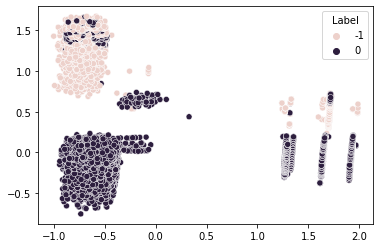

In [64]:
sns.scatterplot(x=pca_components[:, 0],y= pca_components[:, 1], hue=anomaly_labels)

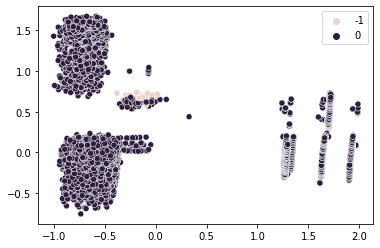

In [65]:
sns.scatterplot(x=pca_components[:, 0],y= pca_components[:, 1], hue=anom_preds)

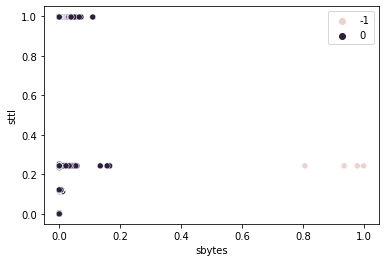

In [66]:
sns.scatterplot(processed_data.sbytes, processed_data.sttl, hue=anom_preds)